In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Xc51-MOFs/WS24-UniMOF/

/content/drive/MyDrive/Xc51-MOFs/WS24-UniMOF


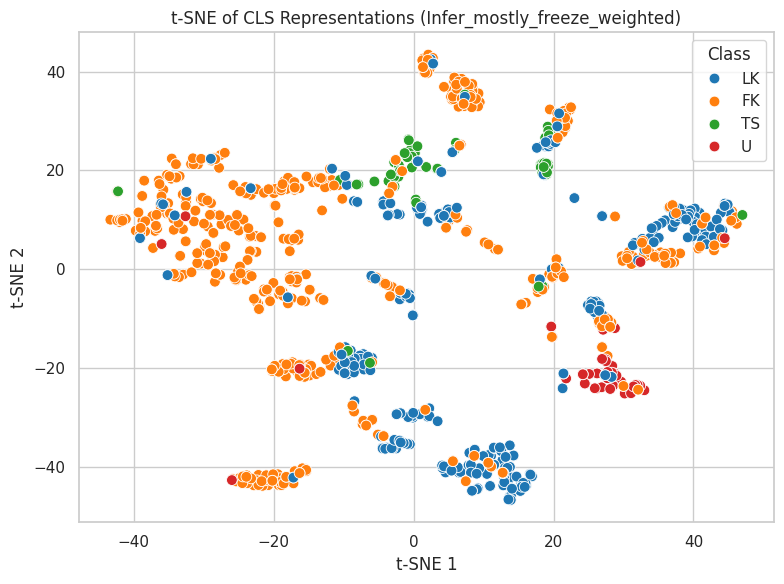

In [9]:
import pickle
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os

# Set seaborn style
sns.set(style="whitegrid")

# Paths to saved CLS and prediction .pkl files (train, valid, test)
base_path = "./evaluation_mostly_freeze_weighted"

repr_paths = {
    "train": os.path.join(base_path, "logs_mostly_freeze_weighted_train_cls_repr.pkl"),
    "valid": os.path.join(base_path, "logs_mostly_freeze_weighted_valid_cls_repr.pkl"),
    "test":  os.path.join(base_path, "logs_mostly_freeze_weighted_test_cls_repr.pkl")
}

pred_paths = {
    "train": os.path.join(base_path, "logs_mostly_freeze_weighted_train_tsne_.out.pkl"),
    "valid": os.path.join(base_path, "logs_mostly_freeze_weighted_valid_tsne_.out.pkl"),
    "test":  os.path.join(base_path, "logs_mostly_freeze_weighted_test_tsne_.out.pkl")
}

# Helper function to load tensor data and convert to numpy if needed
def load_repr(path):
    with open(path, "rb") as f:
        data = pickle.load(f)
        if isinstance(data, torch.Tensor):
            data = data.numpy()
    return data

# Helper function to load predicted labels from tsne output
def load_preds(path):
    with open(path, "rb") as f:
        data = pickle.load(f)
        if isinstance(data, list):
            preds = [int(item['predict'].item()) for item in data]
        else:
            raise ValueError(f"Unexpected data format in {path}: {type(data)}")
        return np.array(preds)

# Load representations and predictions
data_all = []
labels_all = []

for split in ['train', 'valid', 'test']:
    # Load data
    data = load_repr(repr_paths[split])
    preds = load_preds(pred_paths[split])

    # Truncate data if there's a mismatch
    if len(data) > len(preds):
        data = data[:len(preds)]  # Slice to match the number of predictions

    # Ensure lengths match
    assert len(data) == len(preds)

    # Append the data and labels
    data_all.append(data)
    labels_all.append(preds)

# Stack all data and labels
combined_data = np.concatenate(data_all, axis=0)
combined_preds = np.concatenate(labels_all, axis=0)

# Convert integer labels to class names
class_names = {1: "U", 2: "LK", 3: "FK", 4: "TS"}
labels_named = np.array([class_names[label] for label in combined_preds])

# Run t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca', learning_rate='auto')
X_tsne = tsne.fit_transform(combined_data)

# Plot with proper class names
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels_named, palette="tab10", s=60)

# Title and axis labels
plt.title("t-SNE of CLS Representations (Infer_mostly_freeze_weighted)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")

plt.grid(True)
plt.tight_layout()
plt.legend(title="Class")
plt.show()


In [5]:
data_train.shape

(860, 512)

In [7]:
import pickle

with open("./evaluation_mostly_freeze_weighted/logs_mostly_freeze_weighted_test_tsne_.out.pkl", "rb") as f:
    data = pickle.load(f)

print("Type of loaded object:", type(data))
print("Length:", len(data))
print("First element:", data[0])

Type of loaded object: <class 'list'>
Length: 107
First element: {'loss': 0.9296875, 'logits': tensor([[-2.5332, -0.3223,  1.0342,  1.2559]], dtype=torch.float16), 'predict': tensor([4]), 'target': tensor([3.]), 'bsz': 1, 'sample_size': 1}


In [ ]:
pip install umap-learn

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 7.4 MB/s eta 0:00:00a 0:00:01
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.2/26.2 MB 17.2 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/Users/gihyun/Downloads/logs_and_evaluation_data/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gihyun/Downloads/logs_and_evaluation_data/venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


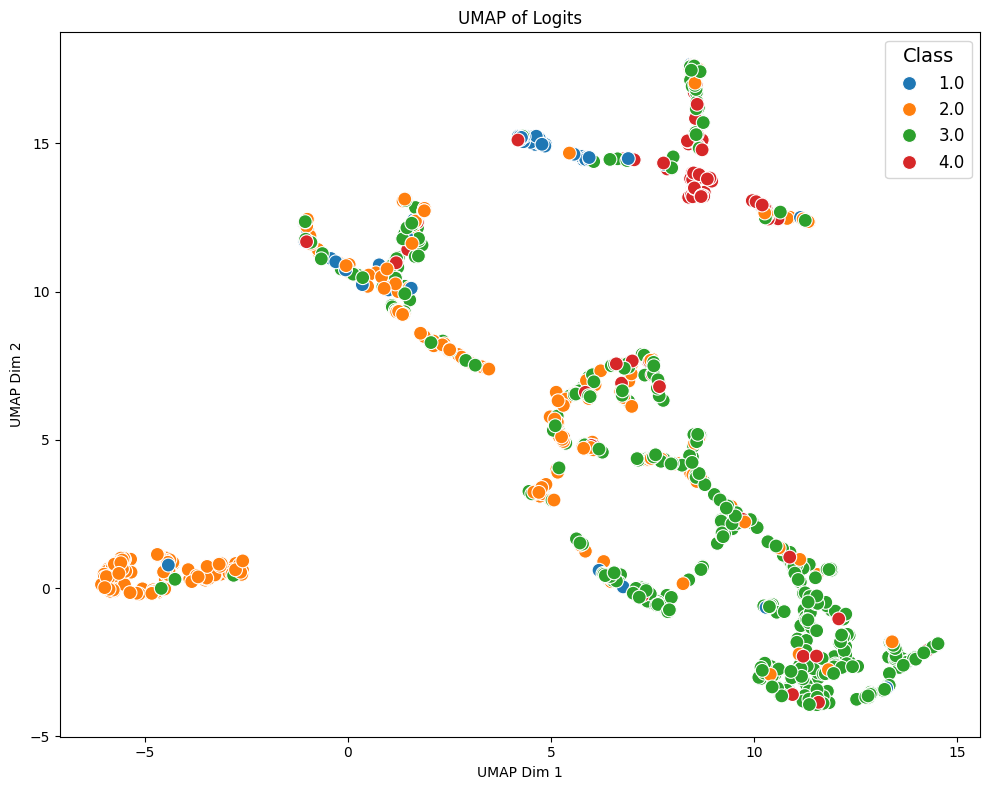

In [ ]:

import umap

# --- Load the .pkl files for all logs ---
log_files = ["evaluation/logs_train.out.pkl", "evaluation/logs_test.out.pkl", "evaluation/logs_valid.out.pkl"]
all_logs = []

# Load each file and append its content
for log_file in log_files:
    with open(log_file, "rb") as f:
        logs = pickle.load(f)
        all_logs.extend(logs)

# --- Extract logits and targets ---
all_logits = [entry["logits"].detach().cpu() for entry in all_logs]
all_targets = [entry["target"].detach().cpu() for entry in all_logs]

logits = torch.cat(all_logits).numpy()
targets = torch.cat(all_targets).numpy()

# --- Apply UMAP ---
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_results = umap_model.fit_transform(logits)

# --- Plot ---
plt.figure(figsize=(10, 8))
sns.scatterplot(x=umap_results[:, 0], y=umap_results[:, 1], hue=targets, palette="tab10", s=100)
plt.title("UMAP of Logits")
plt.xlabel("UMAP Dim 1")
plt.ylabel("UMAP Dim 2")
plt.legend(title="Class", fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.show()
